<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs and Classification
***Classifying subreddit posts***

# Overview
You are an analyst at a social media company which uses targeted advertising on its platform. You have been tasked to create a classification model to identify users who are likely to been keen on *green* products based on their text-based interactions on the platform.

**Goal**: To train a classification model which can **ACCURATELY** distinguish text created by individuals who are motivated to be *green* from those are are *Frugal*. Accuracy and Sensitivity are the key metrics as you would want to get as many ZeroWaste users as possible without making too many mistakes.


## Contents

Part 1: Webscraping, Data Exploration and Data Cleaning <br/>

Part 2: Analysis and Model Tuning (YOU ARE HERE)<br/>
- Model Exploration
- Feature and Error Analysis
- Model Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [306]:
# Imports
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.stem import WordNetLemmatizer
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [263]:
# imports

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix, 
    accuracy_score, 
    plot_roc_curve, 
    roc_auc_score,
    recall_score, 
    precision_score, 
    f1_score,
)

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
# open datafile

df_f = pd.read_csv('./datasets/Frugal_for_analysis.csv')
df_zw = pd.read_csv('./datasets/ZeroWaste_for_analysis.csv')

df = pd.concat([df_f[:10000], df_zw[:10000]], ignore_index = True)

C:\Users\User\AppData\Local\Temp/ipykernel_3680/52418072.py:3: DtypeWarning: Columns (7,10,11,12,21,78,80,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df_f = pd.read_csv('Frugal_for_analysis.csv')
C:\Users\User\AppData\Local\Temp/ipykernel_3680/52418072.py:4: DtypeWarning: Columns (3,10,12,21,29,62,84,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zw = pd.read_csv('ZeroWaste_for_analysis.csv')


# Data Preparation

In [5]:
print(df['subreddit'].value_counts())
df['subreddit'] =  df['subreddit'].map(lambda x: 1 if x == 'ZeroWaste' else 0)

Frugal       10000
ZeroWaste    10000
Name: subreddit, dtype: int64


In [6]:
X = df['fulltext']
y = df['subreddit']
print(y.value_counts())

0    10000
1    10000
Name: subreddit, dtype: int64


In [7]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=28)

<font color = "red">
    
### Caution!!!

The following lines of code will take hours to complete running due to GridSearch.

</font>    

If you wish to avoid this, please run the first few cells where functions are created, and continue from **Feature and Error Analysis**

# Modeling Exploration

To implement GridSearch over a variety of hyperparameters to with two vectorizers (CountVectorizer and TfidfVectorizer) and three classification algorithms (KNearestNeighbor, MultinomialNaiveBayes and RandomForest). The intention is to get an idea of which combination is relatively well on the dataset. A summary of the model performances are at the bottom.

Note: Models were povided with ALL hyperparameters during GridSearch.

In [148]:
# Create function to print model information
# Obtain best model, its hyper parameters, cross_validated_scores
# Scores on train set and test set

def model_info(gs):
    print(gs.best_params_)
    print(f'Cross validated Score is {gs.best_score_}')
    print(f'Train set accuracy is {gs.score(X_train, y_train)}')
    print(f'Test set accuracy is {gs.score(X_test, y_test)}')

In [149]:
# Create function to get confusion matrix

def conf_matrix(gs, train_or_test, X_, y_, model):
    plot_confusion_matrix(gs, X_, y_, cmap='Blues', 
                      values_format='d', display_labels=['Frugal', 'ZeroWaste'])
    plt.title(f"Confusion Matrix for {train_or_test} Set with {model}",
              fontsize=14, y=1.1)


In [364]:
# Function to get sensitivity and specificity

def eval_metrics(gs, train_or_test, X_, y_, model):
    preds = gs.predict(X_)
    tn, fp, fn, tp = confusion_matrix(y_, preds).ravel()
    sensitivity = recall_score(y_, preds)
    specificity = precision_score(y_, preds)
    auc_roc = roc_auc_score(y_, gs.predict_proba(X_)[:,1])
    
    print(f'{model} {train_or_test} set Sensitivity: {sensitivity:.3f}')
    print(f'{model} {train_or_test} set Specificity: {specificity:.3f}')
    print(f'{model} {train_or_test} set AUC ROC: {auc_roc:.3f}')      


In [151]:
# Function to tokenize and create dataframe

def tok(vectorizer, text_liz):
    
    # Instantiate vectorizer
    vec = vectorizer

    # Fit the vectorizer on ZeroWaste text
    vec.fit(text_liz)

    # Transform the data
    dat = vec.transform(text_liz)

    # Convert to a dataframe
    dat = pd.DataFrame(dat.todense(),
                       columns=vec.get_feature_names())
    
    return dat

**Model 1a (CountVectorizer with KNearestNeighbor)**

In [225]:
# Setup pipeline
# 1. CountVectorizer (transformer)
# 2. KNearestNeighbor (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'cvec__max_features': [20_000],
    'cvec__min_df': [3],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english'],
    'knn__n_neighbors': [10, 50, 100]
    
}

gs_cv_knn = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation


In [226]:
# Fit GridSearch to training data.

gs_cv_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [20000],
                         'cvec__min_df': [3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'knn__n_neighbors': [10, 50, 100]})

In [227]:
# Get model information

model_info(gs_cv_knn)

{'cvec__max_df': 0.9, 'cvec__max_features': 20000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'knn__n_neighbors': 100}
Cross validated Score is 0.7789552238805971
Train set accuracy is 0.8097761194029851
Test set accuracy is 0.7786363636363637


In [228]:
# Name model

model_1a = "Model 1a (Cvec with KNN)"

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


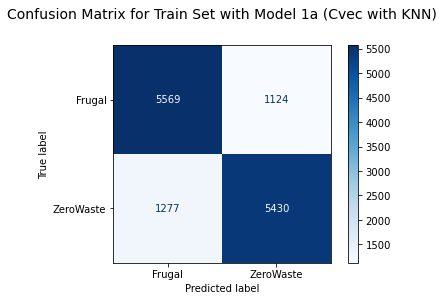

In [105]:
# Confusion matrix for Train set

conf_matrix(gs_cv_knn, "TRA", X_train, y_train, model_1a)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


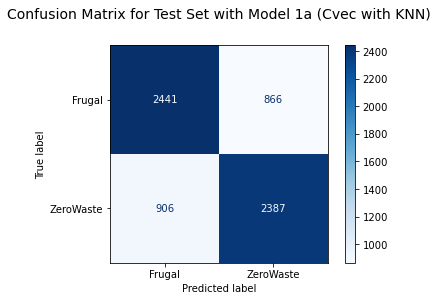

In [106]:
# Confusion matrix for Test set

conf_matrix(gs_cv_knn, "Test", X_test, y_test, model_1a)

In [107]:
# Get evaluation metrics for train set

eval_metrics(gs_cv_knn, "Train", X_train, y_train, model_1a)

Model 1a (Cvec with KNN) Train set Sensitivity: 0.81
Model 1a (Cvec with KNN) Train set Specificity: 0.83
Model 1a (Cvec with KNN) Train set AUC ROC: 0.90


In [108]:
# Get evaluation metrics for test set

eval_metrics(gs_cv_knn, "Test", X_test, y_test, model_1a)

Model 1a (Cvec with KNN) Test set Sensitivity: 0.72
Model 1a (Cvec with KNN) Test set Specificity: 0.73
Model 1a (Cvec with KNN) Test set AUC ROC: 0.81


**Model 1b (TfidfVectorizer with KNearestNeighbor)**

In [404]:
# Setup pipeline
# 1. TfidVectorizer (transformer)
# 2. KNearestNeighbor (estimator)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'tvec__max_features': [5_000, 10_000, 20_000],
    'tvec__min_df': [3, 5],
    'tvec__max_df': [.9, .85],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': ['english'],
    'knn__n_neighbors': [5, 8, 10]
    
}

gs_tvec_knn = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation


In [405]:
# Fit GridSearch to training data.

gs_tvec_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 8, 10],
                         'tvec__max_df': [0.9, 0.85],
                         'tvec__max_features': [5000, 10000, 20000],
                         'tvec__min_df': [3, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']})

In [406]:
# Get model info

model_info(gs_tvec_knn)

{'knn__n_neighbors': 10, 'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Cross validated Score is 0.833358208955224
Train set accuracy is 0.8802985074626866
Test set accuracy is 0.816060606060606


In [407]:
# Name model

model_1b = "Model 1b (Tvec with KNN)"

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


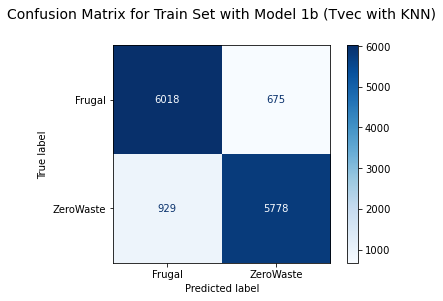

In [408]:
# Confusion matrix for Train set

conf_matrix(gs_tvec_knn, "Train", X_train, y_train, model_1b)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


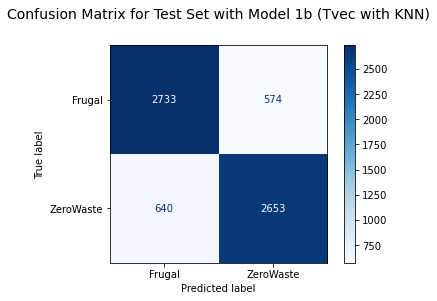

In [409]:
# Confusion matrix for Test set

conf_matrix(gs_tvec_knn, "Test", X_test, y_test, model_1b)

In [410]:
# Get evaluation metrics for train set

eval_metrics(gs_tvec_knn, "Train", X_train, y_train, model_1b)

Model 1b (Tvec with KNN) Train set Sensitivity: 0.861
Model 1b (Tvec with KNN) Train set Specificity: 0.895
Model 1b (Tvec with KNN) Train set AUC ROC: 0.952


In [411]:
# Get evaluation metrics for test set

eval_metrics(gs_tvec_knn, "Test", X_test, y_test, model_1b)

Model 1b (Tvec with KNN) Test set Sensitivity: 0.806
Model 1b (Tvec with KNN) Test set Specificity: 0.822
Model 1b (Tvec with KNN) Test set AUC ROC: 0.894


**Model 2a (CountVectorizer with MultinomialNaiveBayes)**

In [117]:
# Setup pipeline
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [5_000, 10_000, 20_000],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [.9, .85],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english']
    
}

gs_cvec_mnb = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation


In [118]:
# Fit GridSearch to training data

gs_cvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.85],
                         'cvec__max_features': [5000, 10000, 20000],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english']})

In [119]:
# Get model info

model_info(gs_cvec_mnb)

{'cvec__max_df': 0.9, 'cvec__max_features': 20000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
Cross validated Score is 0.8943283582089553
Train set accuracy is 0.9208955223880597
Test set accuracy is 0.8854545454545455


In [120]:
# Name model

model_2a = "Model 2a (Cvec with MNB)"

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


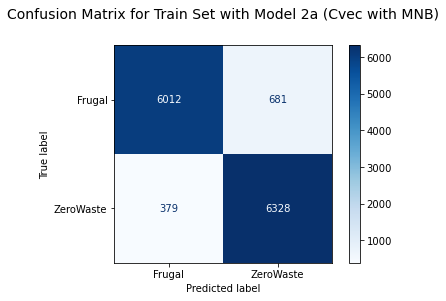

In [121]:
# Confusion matrix for Train set

conf_matrix(gs_cvec_mnb, "Train", X_train, y_train, model_2a)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


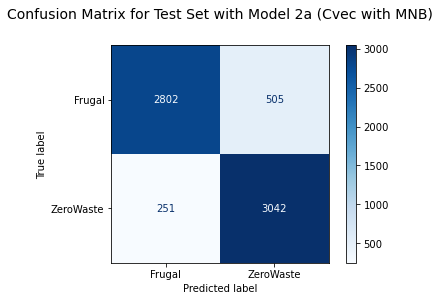

In [122]:
# Confusion matrix for Test set

conf_matrix(gs_cvec_mnb, "Test", X_test, y_test, model_2a)

In [123]:
# Get evaluation metrics for train set

eval_metrics(gs_cvec_mnb, "Train", X_train, y_train, model_2a)

Model 2a (Cvec with MNB) Train set Sensitivity: 0.94
Model 2a (Cvec with MNB) Train set Specificity: 0.90
Model 2a (Cvec with MNB) Train set AUC ROC: 0.97


In [124]:
# Get evaluation metrics for test set

eval_metrics(gs_cvec_mnb, "Test", X_test, y_test, model_2a)

Model 2a (Cvec with MNB) Test set Sensitivity: 0.92
Model 2a (Cvec with MNB) Test set Specificity: 0.86
Model 2a (Cvec with MNB) Test set AUC ROC: 0.95


In [ ]:
# Save relative feature log prob

mnb_cvec_coef = []
for x, y in zip(gs_cvec_mnb.best_estimator_[0].get_feature_names(), gs_cvec_mnb.best_estimator_[1].feature_log_prob_.T):
    mnb_cvec_coef.append(
        {'ngrams':x,
         'coef_0':y[0],
         'coef_1':y[1]
        })

mnb_cvec_coef = pd.DataFrame(mnb_cvec_coef)
mnb_cvec_coef['diff'] = abs(mnb_cvec_coef['coef_0']-mnb_cvec_coef['coef_1'])

mnb_cvec_coef.to_csv(r'mnb_cvec_coef.csv', index=False)

In [117]:
# Save dataframe of tokens

vec =  CountVectorizer(stop_words='english', max_df=0.9, min_df=3,
                max_features=20000, ngram_range=(1,2), )

mnb_cvec_tok = tok(vec, X_train)
mnb_cvec_tok['fulltext'] = list(X_train)
mnb_cvec_tok.to_csv(r'mnb_cvec_tok.csv', index=False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Model 2b (TfidfVectorizer with MultinomialNaiveBayes)**

In [125]:
# Setup pipeline
# 1. TfidVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [5_000, 10_000, 20_000],
    'tvec__min_df': [3, 5],
    'tvec__max_df': [.9, .85],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': ['english']
}

gs_tvec_mnb = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation


In [126]:
# Fit GridSearch to training data

gs_tvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.85],
                         'tvec__max_features': [5000, 10000, 20000],
                         'tvec__min_df': [3, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']})

In [127]:
# Get model info

model_info(gs_tvec_mnb)

{'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Cross validated Score is 0.8931343283582089
Train set accuracy is 0.9244029850746268
Test set accuracy is 0.8846969696969696


In [128]:
# Name model

model_2b = "Model 2b (Tvec with MNB)"

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


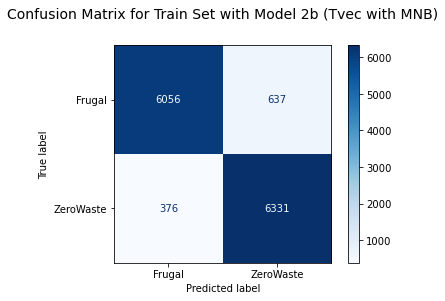

In [129]:
# Confusion matrix for Train set

conf_matrix(gs_tvec_mnb, "Train", X_train, y_train, model_2b)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


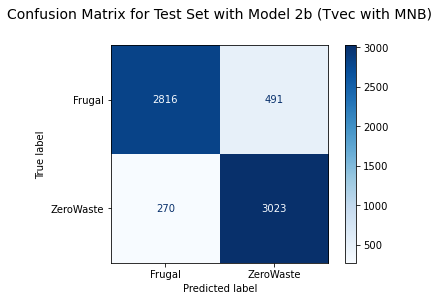

In [130]:
# Confusion matrix for Test set

conf_matrix(gs_tvec_mnb, "Test", X_test, y_test, model_2b)

In [131]:
# Get evaluation metrics for train set

eval_metrics(gs_tvec_mnb, "Train", X_train, y_train, model_2b)

Model 2b (Tvec with MNB) Train set Sensitivity: 0.94
Model 2b (Tvec with MNB) Train set Specificity: 0.91
Model 2b (Tvec with MNB) Train set AUC ROC: 0.98


In [133]:
# Get evaluation metrics for test set

eval_metrics(gs_tvec_mnb, "Test", X_test, y_test, model_2b)

Model 2b (Tvec with MNB) Test set Sensitivity: 0.92
Model 2b (Tvec with MNB) Test set Specificity: 0.86
Model 2b (Tvec with MNB) Test set AUC ROC: 0.95


In [ ]:
# Save relative feature log prob

mnb_tvec_coef = []
for x, y in zip(gs_tvec_mnb.best_estimator_[0].get_feature_names(), gs_tvec_mnb.best_estimator_[1].feature_log_prob_.T):
    mnb_tvec_coef.append(
        {'ngrams':x,
         'coef_0':y[0],
         'coef_1':y[1]
        })

mnb_tvec_coef = pd.DataFrame(mnb_tvec_coef)
mnb_tvec_coef['diff'] = abs(mnb_tvec_coef['coef_0']-mnb_tvec_coef['coef_1'])
mnb_tvec_coef.to_csv(r'mnb_tvec_coef.csv', index=False)

In [118]:
# Save dataframe of tokens

vec =  TfidfVectorizer(stop_words='english', max_df=0.9, min_df=3,
                max_features=20000, ngram_range=(1,2), )

mnb_tvec_tok = tok(vec, X_train)
mnb_tvec_tok['fulltext'] = list(X_train)
mnb_tvec_tok.to_csv(r'mnb_tvec_tok.csv', index=False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Model 3a (CountVectorizer with RandomForest)**

In [157]:
# Setup pipeline
# 1. CountVectorizer (transformer)
# 2. Random Forest Classifier (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'cvec__max_features': [5_000, 10_000, 20_000],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [.85, .9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english'],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 1, 3],
    'rf__min_samples_leaf': [5, 10]
}

gs_cvec_rf = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation


In [158]:
# Fit GridSearch to training data.
gs_cvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 20000],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'rf__max_depth': [None, 1, 3],
                         'rf__min_samples_leaf': [5, 10],
                         'rf__n_estimators': [100, 200]})

In [159]:
# Get model info
model_info(gs_cvec_rf)

{'cvec__max_df': 0.9, 'cvec__max_features': 20000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': None, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
Cross validated Score is 0.8897014925373135
Train set accuracy is 0.9188059701492537
Test set accuracy is 0.8928787878787878


In [160]:
# Name model
model_3a = "Model 3a (Cvec with RF)"

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


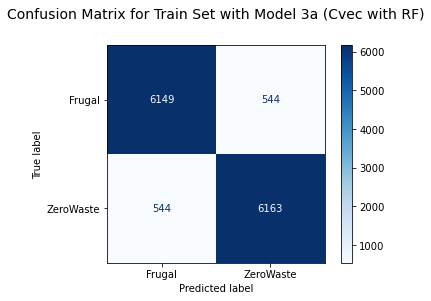

In [161]:
# Confusion matrix for Train set
conf_matrix(gs_cvec_rf, "Train", X_train, y_train, model_3a)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


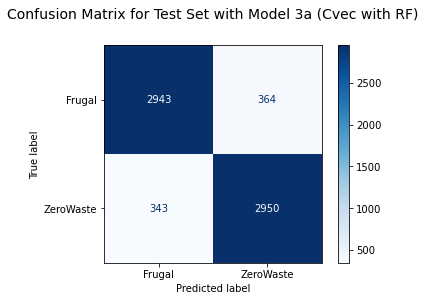

In [162]:
# Confusion matrix for Train set
conf_matrix(gs_cvec_rf, "Test", X_test, y_test, model_3a)

In [163]:
# Get evaluation metrics for train set
eval_metrics(gs_cvec_rf, "Train", X_train, y_train, model_3a)

Model 3a (Cvec with RF) Train set Sensitivity: 0.92
Model 3a (Cvec with RF) Train set Specificity: 0.92
Model 3a (Cvec with RF) Train set AUC ROC: 0.97


In [164]:
# Get evaluation metrics for test set
eval_metrics(gs_cvec_rf, "Test", X_test, y_test, model_3a)

Model 3a (Cvec with RF) Test set Sensitivity: 0.90
Model 3a (Cvec with RF) Test set Specificity: 0.89
Model 3a (Cvec with RF) Test set AUC ROC: 0.96


In [ ]:
# Save Features Importances

feature_names = gs_cvec_rf.best_estimator_[0].get_feature_names()
importances = gs_cvec_rf.best_estimator_[1].feature_importances_

rf_cvec_impt = pd.DataFrame(
    importances,
    index = feature_names,
    columns = ['impurity_dec']
)

rf_cvec_impt.to_csv(r'rf_cvec_impt.csv')

In [120]:
# Save dataframe of tokens

vec =  CountVectorizer(stop_words='english', max_df=0.9, min_df=3,
                max_features=20000, ngram_range=(1,2), )

rf_cvec_tok = tok(vec, X_train)
rf_cvec_tok['fulltext'] = list(X_train)
rf_cvec_tok.to_csv(r'rf_cvec_tok.csv', index=False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [124]:
rf_cvec_tok['fulltext'] = list(X_train)
rf_cvec_tok.to_csv(r'rf_cvec_tok.csv', index=False)

**Model 3b (TfidVectorizer with RandomForest)**

In [171]:
# Setup pipeline
# 1. TfidVectorizer (transformer)
# 2. Random Forest Classifier (estimator)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [20_000, 30_000],
    'tvec__min_df': [3, 4],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': ['english'],
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_leaf': [3, 5]
}

gs_tvec_rf = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation


In [373]:
# Fit GridSearch to training data.
best_tvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None], 'rf__min_samples_leaf': [3],
                         'rf__n_estimators': [300], 'tvec__max_df': [0.9],
                         'tvec__max_features': [30000], 'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': ['english']})

In [374]:
# Get model info
model_info(best_tvec_rf)

{'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 30000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Cross validated Score is 0.8888805970149253
Train set accuracy is 0.9479850746268657
Test set accuracy is 0.894090909090909


In [376]:
# Get evaluation metrics for train set
eval_metrics(best_tvec_rf, "Train", X_train, y_train, model_2b)

Model 2b (Tvec with MNB) Train set Sensitivity: 0.954
Model 2b (Tvec with MNB) Train set Specificity: 0.943
Model 2b (Tvec with MNB) Train set AUC ROC: 0.990


In [377]:
# Get evaluation metrics for test set
eval_metrics(best_tvec_rf, "Test", X_test, y_test, model_2b)

Model 2b (Tvec with MNB) Test set Sensitivity: 0.902
Model 2b (Tvec with MNB) Test set Specificity: 0.888
Model 2b (Tvec with MNB) Test set AUC ROC: 0.959


In [172]:
# Name model
model_3b = "Model 3b (Tvec with RF)" 

In [178]:
# Get model info
model_info(gs_tvec_rf)

{'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 30000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Cross validated Score is 0.8911194029850746
Train set accuracy is 0.9485820895522388
Test set accuracy is 0.8939393939393939


In [173]:
# Fit GridSearch to training data.
gs_tvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__min_samples_leaf': [3, 5],
                         'rf__n_estimators': [200, 300],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [20000, 30000],
                         'tvec__min_df': [3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']})

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


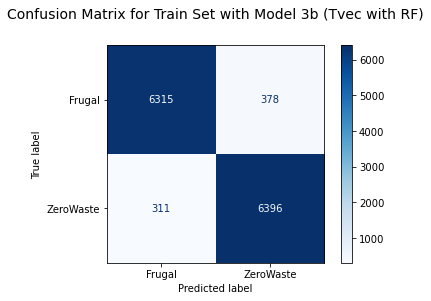

In [174]:
# Confusion matrix for Train set
conf_matrix(gs_tvec_rf, "Train", X_train, y_train, model_3b)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


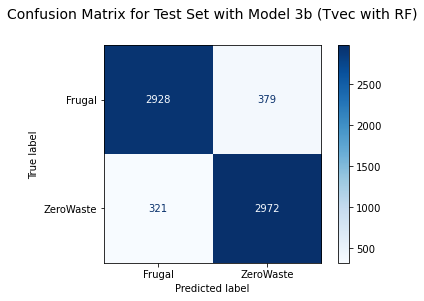

In [175]:
# Confusion matrix for Train set
conf_matrix(gs_tvec_rf, "Test", X_test, y_test, model_3b)

In [176]:
# Get evaluation metrics for train set
eval_metrics(gs_tvec_rf, "Train", X_train, y_train, model_3b)

Model 3b (Tvec with RF) Train set Sensitivity: 0.95
Model 3b (Tvec with RF) Train set Specificity: 0.94
Model 3b (Tvec with RF) Train set AUC ROC: 0.99


In [177]:
# Get evaluation metrics for test set
eval_metrics(gs_tvec_rf, "Test", X_test, y_test, model_3b)

Model 3b (Tvec with RF) Test set Sensitivity: 0.90
Model 3b (Tvec with RF) Test set Specificity: 0.89
Model 3b (Tvec with RF) Test set AUC ROC: 0.96


In [ ]:
# Save Feature Importances

feature_names = gs_tvec_rf.best_estimator_[0].get_feature_names()
importances = gs_tvec_rf.best_estimator_[1].feature_importances_

rf_tvec_impt = pd.DataFrame(
    importances,
    index = feature_names,
    columns = ['impurity_dec']
)

rf_tvec_impt.to_csv(r'rf_tvec_impt.csv')

In [119]:
# Save dataframe of tokens

vec =  TfidfVectorizer(stop_words='english', max_df=0.9, min_df=3,
                max_features=30000, ngram_range=(1,2), )

rf_tvec_tok = tok(vec, X_train)
rf_tvec_tok['fulltext'] = list(X_train)
rf_tvec_tok.to_csv(r'rf_tvec_tok.csv', index=False)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Summary of Models and the "best hyperparameter combination" recommended by GridSearch

|            |                                   | **Max Features** | **Min df** | **Max df**      | **ngram_ range** | **Kneighbours** | **Random Forest params**                                                 |
|------------|-----------------------------------|------------------|------------|-----------------|------------------|-----------------|--------------------------------------------------------------------------|
| **Models** | **GridSearch Parameters**         | **2k-30k**       | **2 - 5**  | **0.85 - 0.95** | **(1,1), (1,2)** | **5-10**        | **n_est: 100-300**<br/> **m_depth: None-10**<br/> **min_leaf:3-10**<br/> |
| Model 1a   | KNN with CountVectorizer          | 5k               | 3          | 0.9             | (1, 1)           | 10              | -                                                                        |
| Model 1b   | KNN with TfidfVectorizer          | 5k               | 3          | 0.9             | (1, 1)           | 10              | -                                                                        |
| Model 2a   | MNB with CountVectorizer          | 20k              | 3          | 0.9             | (1, 2)           | -               | -                                                                        |
| Model 2b   | MNB with TfidfVectorizer          | 20k              | 3          | 0.9             | (1, 2)           | -               | -                                                                        |
| Model 3a   | RF with CountVectorizer           | 20k              | 3          | 0.9             | (1, 2)           | -               | n_est: 200<br/> m_depth: None<br/> min_leaf: 5                           |
| Model 3b   | RF with TfidfVectorizer           | 30k              | 3          | 0.9             | (1, 2)           | -               | n_est: 300<br/> m_depth: None<br/> min_leaf: 3                           |

**Max Features**<br/>
It appears that for all models, gridsearch will reccomend the most number of features available. To consider expanding this limit in future models.

**Min and Max Document Frequency**<br/>
This hyperparameter seems to be rather stable across all models, with Min_df at 3 and Max_df at 0.9.

**n_gram range**<br/>
KNN appears to work best with unigrams while the other models work better with unigrams and bigrams. 

**Other hyperparameters**<br/>
Once again, both KNN and RF appear to reccomend models with more nieghbors and trees respectively. This can be explored later on.

Note: Models were NOT povided with all hyperparameters during GridSearch.

### Summary of Model metrics based on "best hyperparameter combination"

|          |                                   | **Train**    |          |          |             | **Test**     |          |          |             |
|----------|-----------------------------------|--------------|----------|----------|-------------|--------------|----------|----------|-------------|
|          |                                   | **Accuracy** | **Sens** | **Spec** | **AUC ROC** | **Accuracy** | **Sens** | **Spec** | **AUC ROC** |
| Model 1a | CountVectorizer with KNN          | 0.82         | 0.81     | 0.83     | 0.90        | 0.73         | 0.72     | 0.73     | 0.81        |
| Model 1b | TfidfVectorizer with KNN          | 0.87         | 0.85     | 0.88     | 0.95        | 0.81         | 0.80     | 0.82     | 0.89        |
| Model 2a | CountVectorizer with MNB          | 0.90         | 0.93     | 0.89     | 0.96        | 0.88         | 0.92     | 0.86     | 0.95        |
| Model 2b | TfidfVectorizer with MNB          | 0.91         | 0.93     | 0.89     | 0.97        | 0.88         | 0.92     | 0.86     | 0.95        |
| Model 3a | CountVectorizer with RF           | 0.92         | 0.92     | 0.92     | 0.97        | 0.89         | 0.90     | 0.89     | 0.96        |
| Model 3b | TfidfVectorizer with RF           | 0.95         | 0.95     | 0.94     | 0.99        | 0.89         | 0.90     | 0.89     | 0.96        |

**Model performance**<br/>
The results overwhelmingly show that KNearestNeighbor algorithms perform the poorest. The reason for this is probably because KNN performs better when there are smaller number of features and sensitive to noise. Additionally, KNN is the only model that does not utilise bigrams.

RF performs much better than MNB on the train set, however this performance is slighlty muted in the test set. RF and MNB's performance on the test set is close at 88-89%.

**Sensitivity**<br/>
Noted that while RF has better overall accuracy, MNB has better Sensitivity. This means that MNB will be able to identify ZeroWaste users better at the cost of overall accuracy.

**Vectorizer performance**<br/>
In both RF and MNB, TfidVectorizer has much better performance than CountVectorizer on the train set. But this effect is very much tapered in the test set.

**Fitting**<br/>
While it might appear that RF is more prone to overfitting due to the larger difference in the train and test accuracy. The accuracy is currently the best across all models.

### Modelling Summary

RandomForest appears to be slightly better than MNB in terms of overall accuracy on the Test Set. However, MNB has a slightly better sensitivity then RF. Since both models are very close, we will proceed to perform feature analysis on both models.

# Feature and Error Analysis
Using the errors in MNB and RF, we will proceed to inspect the features.


**Investigate most influential features**<br/>1) Top relative feature log prob for MNB models and top feature importances (ie. decrease in impurity) for RF model will be inspected. Words that appear out of place will be added to a stopword list.


**Investigate wrongly classified posts and their words**<br/>
2) Top words in misclassified posts for MNB and RF models will be inspected. Common words which do not fit in either subreddit and are more like "connector" words, they are added to a set of stop words to test later.

<font color = "red">
    
### Caution!!!

This section will not run as the required datasets are not uploaded.
They are more than 1GB which exceeds github's user capacity.
</font> 

Please skip to "Investigate wrongly classified posts and their words"

### Investigate most influential features

In [110]:
# Inspect relative feature log prob for CountVectorizer MNB

mnb_cvec_coef = pd.read_csv('./datasets/mnb_cvec_coef.csv')
mnb_cvec_coef.head()

,ngrams,coef_0,coef_1,diff
0,00,-8.229845,-10.073893,1.844048
1,000,-7.528040,-8.717451,1.189412
2,000 000,-10.895336,-12.907106,2.011771
3,000 miles,-9.419429,-11.808494,2.389065
4,000 month,-11.183018,-12.907106,1.724089


In [196]:
# screened through the top 120 important words
# to identify those that are SUSPICIOUS

mnb_cvec_coef.sort_values('diff', ascending = False)[:10]

,ngrams,coef_0,coef_1,diff
8410,ity,-7.651767,-12.907106,5.255339
8246,insurance,-6.476495,-11.520812,5.044317
15360,shampoo bar,-12.974777,-7.987125,4.987652
16459,straws,-12.974777,-8.047294,4.927483
3444,compostable,-12.281630,-7.434835,4.846794
2562,car insurance,-8.170756,-12.907106,4.736350
19998,zw,-12.974777,-8.243667,4.731110
14377,reducing waste,-12.974777,-8.374507,4.600270
10192,low waste,-11.588483,-7.007209,4.581274
5375,ethique,-12.974777,-8.512657,4.462120


In [104]:
# saved the top words whicha are SUSPICIOUS

mnb_cvec_val = mnb_cvec_coef.T['ngrams'][[19998, 8410, 10785, 439, 14884, 12428]]
mnb_cvec_val

19998                    zw
8410                    ity
10785           message mod
439                     800
14884                    rs
12428    passionate capable
Name: ngrams, dtype: object

In [107]:
# Open tokens file for MNB Cvec

mnb_cvec_tok = pd.read_csv('./datasets/mnb_cvec_tok.csv')
mnb_cvec_tok.shape

(13400, 20001)

In [117]:
# Inspect text of suspicious words (EXAMPLE)

print(mnb_cvec_tok.loc[mnb_cvec_tok['800']>0,"fulltext"].shape)
mnb_cvec_tok.loc[mnb_cvec_tok['800']>0,"fulltext"][:15].values

(78,)


array(["i am moving from vancouver to silicon valley. my company is providing temporary housing, travel expenses etc. they will also cover up to $200 usd worth of excess baggage fees. i am going via air and cannot go by land/car. i am moving in 2 weeks and i have the following options:option 1: use their services to ship up to 10 cubic metres worth of thingsoption 2: take additional $3k lump sum (post tax) and figure it out on my owni am considering option 2 because the only things i would even ship are:1. a double mattress + box spring2. a desk chair that isn't particularly fancy that i got for free3. my digital piano + stand (heavy)4. my bicycle (old and tattered, worth maybe $100)5. maybe 200 lbs worth of boxes with kitchen/office/random household itemsif i take option 2 i wouldn't ship my bed, chair, or bike. these are all things i'd like to have on the other side, and i figure it would cost me probably $800+ for a new bed, $200 for a desk chair, and probably $100-200 for a similar

It appears that the suspicious words which have high relative feature log prob differences are actually spam. Posts that are posted multiple times in varying versions. We shall add this to a stop_word list to remove these words to Prevent OVERFITTING.

In [286]:
# Add to stop_word list

sw_list1 = list(mnb_cvec_val.copy())

In [122]:
# Inspect relative feature log prob for TfidfVectorizer MNB

mnb_tvec_coef = pd.read_csv('./datasets/mnb_tvec_coef.csv')
mnb_tvec_coef.head()

,ngrams,coef_0,coef_1,diff
0,00,-8.612748,-9.991052,1.378304
1,000,-8.049334,-9.236973,1.187640
2,000 000,-10.321826,-10.977333,0.655507
3,000 miles,-9.426152,-10.753935,1.327783
4,000 month,-10.403215,-10.977333,0.574117


In [204]:
# screened through the top 120 important words
# to identify those that are SUSPICIOUS

mnb_tvec_coef.sort_values('diff', ascending = False)[110:120]

,ngrams,coef_0,coef_1,diff
1118,apps,-7.982984,-10.054851,2.071868
4259,deodorant,-9.696162,-7.626701,2.069461
13005,plastic containers,-10.725343,-8.661337,2.064006
12798,phone plan,-8.921703,-10.977333,2.055630
11029,money,-6.124893,-8.180401,2.055508
53,1000,-8.469813,-10.523868,2.054054
3485,conditioner,-9.560319,-7.506740,2.053579
14373,reducing,-10.019605,-7.974317,2.045288
12866,pill bottles,-10.988472,-8.945031,2.043440
281,300,-8.063700,-10.104682,2.040982


In [123]:
mnb_tvec_val =mnb_tvec_coef['ngrams'][[8410, 19998, 400, 53, 281]]
mnb_tvec_val

8410      ity
19998      zw
400       600
53       1000
281       300
Name: ngrams, dtype: object

In [131]:
# Open tokens file for MNB Tvec

mnb_tvec_tok = pd.read_csv('./datasets/mnb_tvec_tok.csv')
mnb_tvec_tok.shape

(13400, 20001)

In [211]:
# Inspect text of suspicious words (EXAMPLE)

print(mnb_tvec_tok.loc[mnb_tvec_tok['zw']>0,"fulltext"].shape)
mnb_tvec_tok.loc[mnb_tvec_tok['zw']>0,"fulltext"][:58].values

(74,)


array(["does anyone have suggestions for  shoe deodorizers? i wear work boots 8 hours a day and am prone to sweaty feet. as you can imagine, my boots are a little rank and i would like to remedy that. i thought about putting them in the washer but i'm not sure if the steel toe would do any damage. zw shoe deodorizer suggestions?",
       "no advice needed, just venting.for a long time i have been at a plateau regarding being low waste. having depression pop up every now and then doesn't help. i have my own personal goals which can be hard to align with my family's.  but then having more waste can also be anxiety inducing as well. having 2 small kids, being in this pandemic, and a few other things make it really challenging sometimes. and sometimes i'm not sure whether to push myself a little more or to give myself some grace. i don't want to act like accomplishing all these zw goals will suddenly make me happy or anything. one small example is that i am not ready to eat at a restaurant

The above this apears to be spam. To add "zw" and common words which are part of spam to stop word list.

In [288]:
# Add to stopword list 

sw_list1.extend(list(mnb_tvec_val))

In [136]:
# Inspect Feature Importances for CountVectorizer RF

rf_cvec_impt = pd.read_csv('./datasets/rf_cvec_impt.csv')
rf_cvec_impt.rename(columns={rf_cvec_impt.columns[0]: "feature"}, inplace=True)
rf_cvec_impt.head()

,feature,impurity_dec
0,00,0.000085
1,000,0.000385
2,000 000,0.000000
3,000 miles,0.000001
4,000 month,0.000000


In [206]:
# screened through the top 120 important words
# to identify those that are SUSPICIOUS

rf_cvec_impt.sort_values('impurity_dec', ascending = False)[100:110]

,feature,impurity_dec
13630,product,0.001876
1485,bank,0.001866
12993,plastic bags,0.001850
6561,gas,0.001832
2627,cardboard,0.001777
102,15,0.001776
395,60,0.001775
10793,metal,0.001771
17398,throw,0.001755
11184,monthly,0.001732


In [139]:
# saved the top words whicha are SUSPICIOUS

rf_cvec_val = rf_cvec_impt['feature'][[15, 350, 151, 8410, 227, 7626, 102, 395, 165, 281]]
rf_cvec_val

15       10
350      50
151      20
8410    ity
227      25
7626     hi
102      15
395      60
165     200
281     300
Name: feature, dtype: object

In [140]:
# Open tokens file for RF Cvec

rf_cvec_tok = pd.read_csv('./datasets/rf_cvec_tok.csv')
rf_cvec_tok.shape

(13400, 20001)

In [210]:
# Inspect text of suspicious words (EXAMPLE)

print(rf_cvec_tok.loc[rf_cvec_tok['10']>0,"fulltext"].shape)
rf_cvec_tok.loc[rf_cvec_tok['10']>0,"fulltext"][:1].values

(714,)


array(["i'm looking for ideas on how/where to score cheap dried fruits and nuts. thinking in the 10/20 lb or so range. i don't mind shopping online or locally (nj, usa). they store well and are nutritional. looking for bulk dried fruits and nuts."],
      dtype=object)

Like in MNB, such words appear to be spam. To add these words as stop words list.

In [290]:
# Add to stopword list 

sw_list1.extend(list(rf_cvec_val))

In [144]:
# Inspect Feature Importances for TfidfVectorizer RF

rf_tvec_impt = pd.read_csv('./datasets/rf_tvec_impt.csv')
rf_tvec_impt.rename(columns={rf_tvec_impt.columns[0]: "feature"}, inplace=True)
rf_tvec_impt.head()

,feature,impurity_dec
0,00,0.000085
1,000,0.000385
2,000 000,0.000000
3,000 miles,0.000001
4,000 month,0.000000


In [145]:
rf_tvec_impt.sort_values('impurity_dec', ascending = False)[90:120]

,feature,impurity_dec
910,alternative,0.002158
14373,reducing,0.002142
1516,bars,0.002097
4522,disposable,0.002077
14299,recyclable,0.002070
4700,dollars,0.001983
6306,free,0.001964
7720,home,0.001920
7626,hi,0.001896
14029,razor,0.001886


In [146]:
# saved the top words whicha are SUSPICIOUS

rf_tvec_val = rf_cvec_impt['feature'][[15, 350, 151, 8410, 227, 7626, 102, 395, 165, 281]]
rf_tvec_val

15       10
350      50
151      20
8410    ity
227      25
7626     hi
102      15
395      60
165     200
281     300
Name: feature, dtype: object

In [147]:
list(rf_cvec_val) == list(rf_tvec_val)

True

As the suspicious words in RF CVEC and RF TVEC are the same, there are no new words to assess, and to add to the stopword list.

**Most influential features**

We have identified and extracted a set of words that are likely to contribute to overfitting (sw_set1), and will use them for model tuning later on. We foresee that this set of words will decrease the accuracy of the train set, as quite a number of them are bases on spam posts. However it should benefit prediction in the long run, as such spam in its exact form is unlikely to exist beyond the reddit environment.

# Investigate wrongly classified posts and their words

For MNB CVEC and RF CVEC best models:
1. To extract all the wrongly classify posts
2. To split posts into False Positive (FP) and False Negative (FN)
3. Perform tokenization on each group and assess the top words.
4. For common words which do not fit in either subreddit and are more like "connector" words, they are added to a set of stop words to test later.

In [179]:
# Create Function to identify classification errors

def find_error(gs):

    error_df_2a = pd.DataFrame()
    error_df_2a['index'] = y_test.index
    error_df_2a['zw_true'] = y_test.values
    error_df_2a['zw_pred'] = gs.predict(X_test)
    error_df_2a.set_index('index', drop= True, inplace=True)
    error_df_2a = pd.concat([error_df_2a, pd.DataFrame(X_test)], axis = 1)
    
    mask = error_df_2a['zw_true']!=error_df_2a['zw_pred'].values
    
    return error_df_2a[mask]

### Investigate wrongly classified tokens in MNB CVEC

In [255]:
# Specify Best cvec MNB Model

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [20_000],
    'cvec__min_df': [3],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': ['english']
    
}

best_cvec_mnb = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [ ]:
# Specify Best tvec MNB Model

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [20_000],
    'tvec__min_df': [3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': ['english']
    
}

best_tvec_mnb = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [ ]:
# Specify Best cvec RF Model

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'cvec__max_features': [20_000],
    'cvec__min_df': [3],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'cvec__stop_words': ['english'],
    'rf__n_estimators': [200],
    'rf__max_depth': [None],
    'rf__min_samples_leaf': [5]
    
}

best_cvec_rf = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [ ]:
# Specify Best tvec RF Model

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__min_df': [3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': ['english'],
    'rf__n_estimators': [300],
    'rf__max_depth': [None],
    'rf__min_samples_leaf': [3]
}

best_tvec_rf = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [227]:
# Extract wrongly classified posts for MNB CVEC

cvec_mnb_error = find_error(best_cvec_mnb)
cvec_mnb_error.head()

,zw_true,zw_pred,fulltext
18521,1,0,"hey guys, i'm in the market to buy a used lapt..."
2929,0,1,i do this already. we reuse them for non-food...
17476,1,0,i had a minor realization recently. i had a ca...
7455,0,1,topic: why are paper towels so darn expensive?...
12926,1,0,i've had a pretty poor experience with public ...


In [215]:
# Extract False Negatives and False Positives into separate datasets

cvec_mnb_FN = cvec_mnb_error.loc[cvec_mnb_error['zw_true']==1,'fulltext']
cvec_mnb_FP = cvec_mnb_error.loc[cvec_mnb_error['zw_true']==0,'fulltext']

2929    i do this already.  we reuse them for non-food...
7455    topic: why are paper towels so darn expensive?...
1109    hi,does anyone know how much pact's cotton tee...
3105    dear all,i have a bunch of hoodies, a tent and...
4450    recently i have had a difficult time throwing ...
                              ...                        
8726    i'm not sure if these products would be consid...
8296    i'm gonna start this post by clarifying that 9...
1022    there's so many different kinds what's the bes...
8928    i rent a granny flat and have a small porch. i...
5374    go to walmart. they have their mainstays brand...
Name: fulltext, Length: 505, dtype: object

In [216]:
# Create tokens for the "wronfly classified data" datasets for MNB CVEC

vec = CountVectorizer(stop_words = 'english',
                max_features = 20_000,
                min_df = 3,
                max_df = .9,
                ngram_range = (1, 2))

cvec_mnb_FN_corp = tok(vec, cvec_mnb_FN)
cvec_mnb_FP_corp = tok(vec, cvec_mnb_FP)

In [236]:
cvec_mnb_FN_corp.sum().sort_values(ascending=False)[20:40]

years      50
really     49
waste      49
work       48
got        46
clothes    46
money      42
going      40
year       38
free       36
looking    36
food       35
way        34
feel       34
hand       34
stuff      34
sell       34
doesn      33
car        33
live       33
dtype: int64

In [237]:
cvec_mnb_FP_corp.sum().sort_values(ascending=False)[20:40]

people      79
clothes     77
way         74
food        73
using       72
ideas       70
does        69
products    67
lot         66
bought      64
old         64
plastic     63
little      62
store       62
work        59
cheap       58
wash        57
buying      56
years       55
away        55
dtype: int64

In [285]:
# add potential stopwords to list

sw_list2 = ["just", "don", "new", "like", "want", "buy", "ve", "know"]

### Investigate wrongly classified tokens in RF CVEC

In [228]:
# Assess wrongly classified posts for RF CVEC

cvec_rf_error = find_error(best_cvec_rf)
cvec_rf_error.head()

,zw_true,zw_pred,fulltext
18521,1,0,"hey guys, i'm in the market to buy a used lapt..."
2929,0,1,i do this already. we reuse them for non-food...
17476,1,0,i had a minor realization recently. i had a ca...
12926,1,0,i've had a pretty poor experience with public ...
8312,0,1,does anyone know if t-mobile forces apple’s ca...


In [229]:
# Extract False Negatives and False Positives into separate datasets

cvec_rf_FN = cvec_rf_error.loc[cvec_rf_error['zw_true']==1,'fulltext']
cvec_rf_FP = cvec_rf_error.loc[cvec_rf_error['zw_true']==0,'fulltext']

In [230]:
# Create tokens for the "wronfly classified data" datasets for MNB CVEC

cvec_rf_FN_corp = tok(vec, cvec_rf_FN)
cvec_rf_FP_corp = tok(vec, cvec_rf_FP)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [231]:
cvec_rf_FN_corp.sum().sort_values(ascending=False).head(25)

just       173
like       164
don        145
buy        116
want       114
new        114
ve         107
know       106
people      94
used        93
use         92
need        86
time        81
good        80
make        77
water       77
really      74
things      70
buying      66
clothes     64
old         62
think       62
money       59
years       56
store       55
dtype: int64

In [232]:
cvec_rf_FP_corp.sum().sort_values(ascending=False).head(25)

use        231
just       168
like       152
don        128
make       121
ve         102
water       99
know        94
buy         84
used        79
want        77
good        74
need        72
things      71
soap        70
really      70
people      69
ideas       69
paper       67
new         66
time        61
using       58
way         58
plastic     57
looking     55
dtype: int64

**Top words in wrongly classified posts**

Some of the words can be considered for stop words as their qualitative meaning do not fit ZeroWaste or Frugal e.g.("use", "like", "just"). This finding concurs with the exploratory data analysis at the beggining, where a number of these words

Some of the posts are classified as False Negatives as they contain words such as ("money", "old", "free"). Some of the posts are classified as False Positives as they contain words such as ("soap", "plastic"). However we will not remove these words as they would help classify majority of the posts.

In [311]:
sw_set1

{'10',
 '1000',
 '15',
 '20',
 '200',
 '25',
 '300',
 '50',
 '60',
 '600',
 '800',
 'hi',
 'ity',
 'message mod',
 'passionate capable',
 'rs',
 'zw'}

In [250]:
# add potential stopwords to stopwords set 2

sw_set2 = ("just", "don", "new", "like", "want", "buy", "ve", "know", "really", "make")

## Model Tuning

Using the insights from above we will further tune the models by adding a variety of stop words to the models.

Stop Words lists to test:
1) Set 1: Most influential features that contribute to overfitting <br/>
2) Set 2: Top words in wrongly classified posts that do not contribute to prediction


In [337]:
# Update StopWords sets

# Set 1: Countvectorizer stopwords PLUS 
#        Most influential features that contribute to overfitting
sw_1 = set(CountVectorizer(stop_words = 'english').get_stop_words())
sw_1.update(sw_set1)

# Set 2: Countvectorizer stopwords PLUS 
#        Top words in wrongly classified posts that do not contribute to prediction
sw_2 = sw_1.copy()
sw_2.update(sw_set2)

**Model 2b_sw1 (Tvec with MNB, sw1 stopwords)**

In [343]:
# Specify Best tvec MNB Model with stopwords sw_1

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [20_000],
    'tvec__min_df': [3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [sw_1],
    
}

sw1_tvec_mnb = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [344]:
# Fit Model to training data.

sw1_tvec_mnb.fit(X_train, y_train)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with you

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [20000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [{'10', '1000', '15', '20', '200',
                                               '25', '300', '50', '60', '600',
                                               '800', 'a', 'about', 'above',
                                               'across', 'after', 'afterwards',
                                               'again', 'against', 'all',
                                               'almost', 'alone', 'along',
                                               'already', 'also', 'although',
                                               'always', 'am', 'among',
                                               'amongst', ...}]})

In [345]:
# Get model info

model_info(sw1_tvec_mnb)

{'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': {'last', 'noone', 'ourselves', '600', 'own', 'call', 'detail', 'go', 'would', 'formerly', 'are', 'become', 'put', 'side', 'anywhere', '60', 'fifty', 'beforehand', 'a', 'yours', 'thereupon', 'whereas', 'found', 'from', 'back', 'in', 'have', 'its', 'her', 'six', 'there', 'further', 'per', 'even', 'except', 'first', 'him', 'which', 'the', 'against', 'being', 'several', 'every', 'themselves', 'over', 'seems', 'now', 'name', '20', 'keep', 'hereby', 'but', 'two', 'thick', 'either', 'onto', 'seem', 'and', 'am', 'once', 'all', 'our', 'whereby', 'namely', 'if', 'hasnt', 'cant', 'hundred', 'less', 'whoever', '50', 'perhaps', 'otherwise', 'therein', 'moreover', 'therefore', 'no', 'nobody', 'each', 'also', 'his', 'see', 'message mod', 'something', 'eg', 'get', 'most', 'some', 'what', 'third', '10', 'them', 'becoming', 'nevertheless', 'anyone', 'thence', 'amoungst', 'latterly', 'al

In [358]:
# Name model

model_2b_sw1 = "Model 2b_sw1 (Tvec with MNB, sw1 stopwords)"

In [ ]:
# Get evaluation metrics for train set
eval_metrics(sw1_tvec_mnb, "Train", X_train, y_train, model_2b_sw1)

In [369]:
# Get evaluation metrics for test set
eval_metrics(sw1_tvec_mnb, "Test", X_test, y_test, model_2b_sw1)

Model 2b (Tvec with MNB, sw1 stopwords) Test set Sensitivity: 0.916
Model 2b (Tvec with MNB, sw1 stopwords) Test set Specificity: 0.859
Model 2b (Tvec with MNB, sw1 stopwords) Test set AUC ROC: 0.952


**Model 2b_sw2 (Tvec with MNB, sw2 stopwords)**

In [346]:
# Specify Best tvec MNB Model with stopwords sw_2

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [20_000],
    'tvec__min_df': [3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [sw_2],
    
}

sw2_tvec_mnb = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [347]:
# Fit Model to training data.

sw2_tvec_mnb.fit(X_train, y_train)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with you

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [20000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [{'10', '1000', '15', '20', '200',
                                               '25', '300', '50', '60', '600',
                                               '800', 'a', 'about', 'above',
                                               'across', 'after', 'afterwards',
                                               'again', 'against', 'all',
                                               'almost', 'alone', 'along',
                                               'already', 'also', 'although',
                                               'always', 'am', 'among',
                                               'amongst', ...}]})

In [348]:
# Get model info

model_info(sw2_tvec_mnb)

{'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': {'last', 'noone', 'ourselves', '600', 'own', 'call', 'detail', 'go', 'would', 'formerly', 'are', 'become', 'put', 'side', 'anywhere', '60', 'fifty', 'beforehand', 'a', 'yours', 'thereupon', 'whereas', 'found', 'from', 'back', 'in', 'have', 'its', 'her', 'six', 'there', 'further', 'per', 'even', 'except', 'first', 'him', 'which', 'the', 'against', 'being', 'several', 'every', 'themselves', 'over', 'seems', 'now', 'name', '20', 'keep', 'hereby', 'but', 'two', 'thick', 'either', 'onto', 'seem', 'and', 'am', 'once', 'all', 'our', 'whereby', 'namely', 'if', 'hasnt', 'cant', 'hundred', 'less', 'whoever', '50', 'perhaps', 'otherwise', 'know', 'therein', 'moreover', 'therefore', 'no', 'nobody', 'each', 'also', 'his', 'see', 'message mod', 'something', 'eg', 'get', 'most', 'some', 'what', 'don', 'third', '10', 'them', 'becoming', 'nevertheless', 'anyone', 'thence', 'amoungst', 

In [361]:
# Name model

model_2b_sw2 = "Model 2b_sw2 (Tvec with MNB, sw2 stopwords)"

In [370]:
# Get evaluation metrics for train set
eval_metrics(sw2_tvec_mnb, "Train", X_train, y_train, model_2b_sw2)

Model 2b (Tvec with MNB, sw2 stopwords) Train set Sensitivity: 0.942
Model 2b (Tvec with MNB, sw2 stopwords) Train set Specificity: 0.909
Model 2b (Tvec with MNB, sw2 stopwords) Train set AUC ROC: 0.975


In [371]:
# Get evaluation metrics for test set
eval_metrics(sw2_tvec_mnb, "Test", X_test, y_test, model_2b_sw2)

Model 2b (Tvec with MNB, sw2 stopwords) Test set Sensitivity: 0.912
Model 2b (Tvec with MNB, sw2 stopwords) Test set Specificity: 0.860
Model 2b (Tvec with MNB, sw2 stopwords) Test set AUC ROC: 0.952


**Model 3b_sw1 (Tvec with RF, sw1 stopwords)**

In [378]:
# Specify Best tvec RF Model wtih stopwords sw_1

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__min_df': [3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [sw_1],
    'rf__n_estimators': [300],
    'rf__max_depth': [None],
    'rf__min_samples_leaf': [3]
    
}

sw1_tvec_rf = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [379]:
# Fit Model to training data.

sw1_tvec_rf.fit(X_train, y_train)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with you

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None], 'rf__min_samples_leaf': [3],
                         'rf__n_estimators': [300], 'tvec__max_df': [0.9],
                         'tvec__max_features': [30000], 'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [{'10', '1000', '15', '20', '200',
                                               '25', '300', '50', '60', '600',
                                               '800', 'a', 'about', 'above',
                                               'across', 'after', 'afterwards',
                                               'again', 'against', 'all',
                                               'almost', 'alone', 'along',
                                               'already', 'also', 'although',
        

In [383]:
# Get model info

model_info(sw1_tvec_rf)

{'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 30000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': {'last', 'noone', 'ourselves', '600', 'own', 'call', 'detail', 'go', 'would', 'formerly', 'are', 'become', 'put', 'side', 'anywhere', '60', 'fifty', 'beforehand', 'a', 'yours', 'thereupon', 'whereas', 'found', 'from', 'back', 'in', 'have', 'its', 'her', 'six', 'there', 'further', 'per', 'even', 'except', 'first', 'him', 'which', 'the', 'against', 'being', 'several', 'every', 'themselves', 'over', 'seems', 'now', 'name', '20', 'keep', 'hereby', 'but', 'two', 'thick', 'either', 'onto', 'seem', 'and', 'am', 'once', 'all', 'our', 'whereby', 'namely', 'if', 'hasnt', 'cant', 'hundred', 'less', 'whoever', '50', 'perhaps', 'otherwise', 'therein', 'moreover', 'therefore', 'no', 'nobody', 'each', 'also', 'his', 'see', 'message mod', 'something', 'eg', 'get', 'most', 'some', 'what', 'third', '10', 'them', 

In [380]:
# Name model

model_3b_sw1 = "Model 3b_sw1 (Tvec with RF, sw1 stopwords)"

In [381]:
# Get evaluation metrics for train set
eval_metrics(sw1_tvec_rf, "Train", X_train, y_train, model_3b_sw1)

Model 3b_sw1 (Tvec with RF, sw1 stopwords)) Train set Sensitivity: 0.953
Model 3b_sw1 (Tvec with RF, sw1 stopwords)) Train set Specificity: 0.943
Model 3b_sw1 (Tvec with RF, sw1 stopwords)) Train set AUC ROC: 0.990


In [382]:
# Get evaluation metrics for test set
eval_metrics(sw1_tvec_rf, "Test", X_test, y_test, model_3b_sw1)

Model 3b_sw1 (Tvec with RF, sw1 stopwords)) Test set Sensitivity: 0.903
Model 3b_sw1 (Tvec with RF, sw1 stopwords)) Test set Specificity: 0.886
Model 3b_sw1 (Tvec with RF, sw1 stopwords)) Test set AUC ROC: 0.959


**Model 3b_sw2 (Tvec with RF, sw2 stopwords)**

In [399]:
# Specify Best tvec RF Model wtih stopwords sw_2

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tvec__max_features': [30_000],
    'tvec__min_df': [3],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,2)],
    'tvec__stop_words': [sw_2],
    'rf__n_estimators': [300],
    'rf__max_depth': [None],
    'rf__min_samples_leaf': [3]
    
}

sw2_tvec_rf = GridSearchCV(pipe,
                  param_grid=pipe_params, # search parameters
                  cv=5)                   # 5-fold cross-validation

In [400]:
# Fit Model to training data.

sw2_tvec_rf.fit(X_train, y_train)

C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['capable', 'message', 'mod', 'passionate'] not in stop_words.
  warnings.warn(
C:\Users\User\.conda\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with you

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None], 'rf__min_samples_leaf': [3],
                         'rf__n_estimators': [300], 'tvec__max_df': [0.9],
                         'tvec__max_features': [30000], 'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [{'10', '1000', '15', '20', '200',
                                               '25', '300', '50', '60', '600',
                                               '800', 'a', 'about', 'above',
                                               'across', 'after', 'afterwards',
                                               'again', 'against', 'all',
                                               'almost', 'alone', 'along',
                                               'already', 'also', 'although',
        

In [401]:
# Get model info

model_info(sw2_tvec_rf)

{'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 300, 'tvec__max_df': 0.9, 'tvec__max_features': 30000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': {'last', 'noone', 'ourselves', '600', 'own', 'call', 'detail', 'go', 'would', 'formerly', 'are', 'become', 'put', 'side', 'anywhere', '60', 'fifty', 'beforehand', 'a', 'yours', 'thereupon', 'whereas', 'found', 'from', 'back', 'in', 'have', 'its', 'her', 'six', 'there', 'further', 'per', 'even', 'except', 'first', 'him', 'which', 'the', 'against', 'being', 'several', 'every', 'themselves', 'over', 'seems', 'now', 'name', '20', 'keep', 'hereby', 'but', 'two', 'thick', 'either', 'onto', 'seem', 'and', 'am', 'once', 'all', 'our', 'whereby', 'namely', 'if', 'hasnt', 'cant', 'hundred', 'less', 'whoever', '50', 'perhaps', 'otherwise', 'know', 'therein', 'moreover', 'therefore', 'no', 'nobody', 'each', 'also', 'his', 'see', 'message mod', 'something', 'eg', 'get', 'most', 'some', 'what', 'don', 'third',

In [390]:
# Name model

model_3b_sw2 = "Model 3b_sw2 (Tvec with MNB, sw2 stopwords)"

In [391]:
# Get evaluation metrics for train set
eval_metrics(sw2_tvec_rf, "Train", X_train, y_train, model_3b_sw2)

Model 3b_sw2 (Tvec with MNB, sw2 stopwords) Train set Sensitivity: 0.952
Model 3b_sw2 (Tvec with MNB, sw2 stopwords) Train set Specificity: 0.942
Model 3b_sw2 (Tvec with MNB, sw2 stopwords) Train set AUC ROC: 0.989


In [392]:
# Get evaluation metrics for test set
eval_metrics(sw2_tvec_rf, "Test", X_test, y_test, model_3b_sw2)

Model 3b_sw2 (Tvec with MNB, sw2 stopwords) Test set Sensitivity: 0.905
Model 3b_sw2 (Tvec with MNB, sw2 stopwords) Test set Specificity: 0.889
Model 3b_sw2 (Tvec with MNB, sw2 stopwords) Test set AUC ROC: 0.959


#### Summary of Models with the "best hyperparameter combination" with different stopword sets

|              |                        | **Train**    |          |          | **Test**     |          |          |
|:-------------|:-----------------------|--------------|----------|----------|--------------|----------|----------|
|              |                        | **Accuracy** | **Sens** | **Spec** | **Accuracy** | **Sens** | **Spec** |
| Model 2b     | MNB original Stopwords | 0.924        | 0.944    | 0.909    | 0.884        | 0.918    | 0.860    |
| Model 2b_sw1 | MNB Stopwords set1     | 0.924        | 0.941    | 0.910    | 0.883        | 0.916    | 0.859    |
| Model 2b_sw2 | MNB Stopwords set2     | 0.924        | 0.942    | 0.909    | 0.882        | 0.912    | 0.860    |
| Model 3b     | RF original Stopwords  | 0.948        | 0.954    | 0.943    | 0.894        | 0.902    | 0.888    |
| Model 3b_sw1 | RF Stopwords set1      | 0.948        | 0.953    | 0.943    | 0.894        | 0.903    | 0.886    |
| Model 3b_sw2 | RF Stopwords set2      | 0.947        | 0.952    | 0.942    | 0.896        | 0.905    | 0.889    |

**Model Tuning**<br/>
As seen in the table there were minimal changes in the Accuracy and Sensitivity scores after including the extra stopwords. This is probably because the number of words removed are relatively small compared to the number of features in the corpus.

Nonethless, we can see small improvements in the Accuracy and Sensitivity of the RandomForest models when more stopwords are included (ie better overall classification and better identification of ZeroWaste users). This could be indicative that further tuning of the stopwords can result in a better performance.

## Conclusions and Reccomendations

This project set out to identify 'green' users by their text-based social media posts to improve targeted advertising on said users. To achieve this, subreddit posts from 'ZeroWaste' and 'Frugal' were scraped to create a set of text based data which have similar meanings. The goal was to classify these two groups with good overall accuracy and sensitivity. This is to ensure that we could identify the target users well, but at the same time not include too many errors.

An exploratory analysis showed promise as the top words in each of the subreddits included distinct words that were reflective of their underlying motivations. (e.g. "save money" and "time" in Frugal, "plastic" and "eco friendly" in ZeroWaste). If the posts contained distinctive words that are representative of its subreddit it should be correctly classified. Of course, words such as "waste" were popular in both subreddits.

An iterative search process using GridSearch led to a decently performing model with the RandomForest algorithm. An accuracy of 89% and sensitivity of 90% was achieved, which meant that we are able to classify ZeroWaste users apart from relatively similar users rather well. The effects of removing tokens from spam entries cannot be seen at this point, but could be salient when the model is deployed on real posts. Likewise the removal of tokens which are common and without logical affliation with either subreddits did not yield conclusive improvements.

Nonetheless the algorithm is performing relatively well, and will be able to identify ZeroWaste users to a high accuracy. We will reccomend for the RandomForest model with TfdifVectorizer and all the identified stopwords to be deployed for use.

## Future Directions

1) Combine predictions with other behaviours on the social media platform<br/>
Incorporate users "likes" and "groups" to boost the performance of the classification

2) Investigate wrongly classified posts in fulltext form<br/>
Could the wrongly classified posts be semantically suitable for both groups?

1) Refine list of Stop Words<br/>
During the analysis, we spotted many other common words in both dataset that could have added to the noise in classification. Future modelling can consider increasing the stop word list to reduce the variance in the model.

2) Stemming and Lemmatizing<br/>
Further adjustment of the word forms can be attempted to boost the weights of influential words that are present in various forms.



In [403]:
%%html
<style>
table {float:left}
</style>